# Now that we have all the Data ready we can begin our Analysis.

## Inspecting the Data

In [33]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, boxcox, yeojohnson
from typing import Tuple

In [ ]:
# Taking 10% data 

PERCENTAGE = 0.10

file_path = f'..\\resources\\toxicity_analysis_{PERCENTAGE:.0%}_data.tsv'

try:
    toxicity_analysis_df = pd.read_csv(file_path, sep="\t")  
except Exception as e:
    print(f"Error loading file: {e}")

In [35]:
toxicity_analysis_df

,subreddit_category,word_count,preprocessed,toxicity_label
0,Advice,228,"i 'm 23 , moved back in with parents . how do ...",0
1,Advice,143,always feel an overwhelming lack of confidence...,0
2,Advice,233,"dealing with this break up hey there , this mo...",0
3,Advice,398,disagreement when picking rooms in the new hou...,0
4,Advice,226,i do n't know what i believe i do n't typicall...,0
...,...,...,...,...
11648,weddingplanning,236,budgeting .. where to start ? hi weddit ! firs...,0
11649,weddingplanning,370,disagreement with fh about one person 's weddi...,0
11650,weddingplanning,289,what 's next ? destination wedding we are gett...,0
11651,weddingplanning,353,how do i manage a tricky situation with my fut...,0


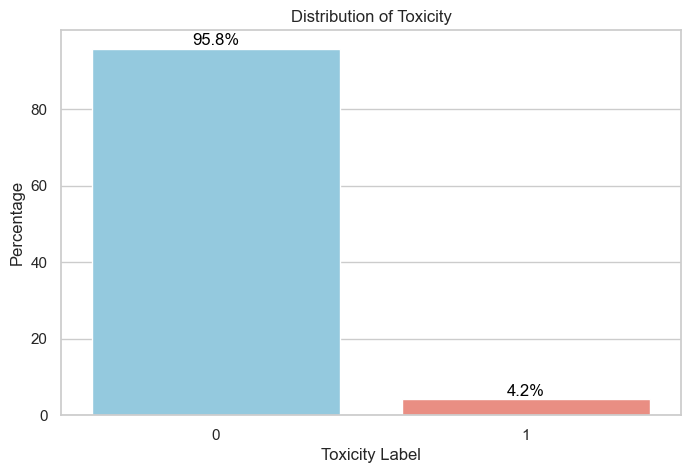

In [36]:
# Calculation of the proportions
category_counts = toxicity_analysis_df.groupby('toxicity_label').size().reset_index(name='count')

# Calculate the total for the procentual proportions
total_counts = category_counts['count'].sum()
category_counts['percentage'] = (category_counts['count'] / total_counts) * 100

# Plot the data 
plt.figure(figsize=(8, 5))
sns.barplot(data=category_counts, x='toxicity_label', y='percentage', hue='toxicity_label', palette=['skyblue', 'salmon'], legend=False)
plt.title('Distribution of Toxicity')
plt.ylabel('Percentage')
plt.xlabel('Toxicity Label') 
plt.yticks(range(0, 100, 20))
for index, row in category_counts.iterrows():
    plt.text(index, row['percentage'] + 1, f"{row['percentage']:.1f}%", color='black', ha='center')

plt.show()


We could assume that 95.8% of the reddit comments are non-toxic.

# Hypothesis: There are significant differences in toxicity between the different subreddit categories.
# Null-Hypothesis: There are no significant differences in toxicity between the different subreddit categories.

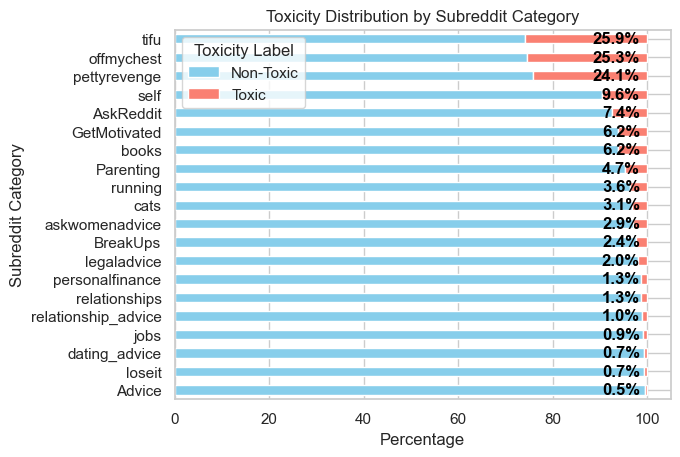

In [37]:
# Include only categories with at least one toxic post
toxic_categories = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['subreddit_category'].unique()
toxic_only_df = toxicity_analysis_df[toxicity_analysis_df['subreddit_category'].isin(toxic_categories)]

# Calculate toxicity percentages by category
category_counts = toxic_only_df.groupby(['subreddit_category', 'toxicity_label']).size().unstack(fill_value=0)
category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

# Sort by toxicity percentage (in ascending order)
category_percentages = category_percentages.sort_values(by=1)

# Plot the data
ax = category_percentages.plot(kind='barh', stacked=True, color=['skyblue', 'salmon'])
plt.title('Toxicity Distribution by Subreddit Category')
plt.xlabel('Percentage')
plt.ylabel('Subreddit Category')
plt.legend(['Non-Toxic', 'Toxic'], title='Toxicity Label')

# Add right-aligned percentages on the toxic bars 
for index, (category, values) in enumerate(category_percentages.iterrows()):
    toxic_percentage = values[1]
    non_toxic_percentage = values[0]
    if toxic_percentage > 0:  # Only label toxic bars
        ax.text(non_toxic_percentage + toxic_percentage - 1.5, index, f'{toxic_percentage:.1f}%',
                va='center', ha='right', color='black', fontweight='bold')

plt.show()

Above is the result if we don't take the number of posts in their category into account. Does that make a difference?

In [38]:
# Look at proportions: How many Posts does each Toxic Category have in total?
category_counts = toxic_only_df['subreddit_category'].value_counts()
category_counts

subreddit_category
relationships          6331
AskReddit              1543
relationship_advice     868
tifu                    768
dating_advice           284
personalfinance         230
Advice                  208
legaladvice             199
offmychest              158
loseit                  144
jobs                    108
self                    104
BreakUps                 83
askwomenadvice           68
running                  56
pettyrevenge             54
Parenting                43
cats                     32
books                    16
GetMotivated             16
Name: count, dtype: int64

We have a Problem: The Category "pettyrevenge" or "offmychest" have a comparable toxic-percentage to "tifu". <br>
But we can also see that the "pettyrevenge" Category has only 54 entries, whereas the "tifu" Category has 768 entries. <br> So it's not a very good comparison.
Let's try to calculcate a weighted toxicity percentage.

In [39]:
# Count total entries and toxic entries for each category
category_counts = toxicity_analysis_df.groupby('subreddit_category')['toxicity_label'].agg(['count', 'sum']).reset_index()

# Calculate toxicity percentage and weighted toxicity score
category_counts['toxicity_percentage'] = category_counts['sum'] / category_counts['count'] * 100
category_counts['weighted_toxicity'] = category_counts['sum'] / (category_counts['count']**0.5)

# Include only categories with at least one toxic entry
category_counts = category_counts[category_counts['sum'] > 0]
category_counts = category_counts.reset_index(drop=True)

category_counts

,subreddit_category,count,sum,toxicity_percentage,weighted_toxicity
0,Advice,208,1,0.480769,0.069338
1,AskReddit,1543,114,7.388205,2.902164
2,BreakUps,83,2,2.409639,0.219529
3,GetMotivated,16,1,6.250000,0.250000
4,Parenting,43,2,4.651163,0.304997
5,askwomenadvice,68,2,2.941176,0.242536
6,books,16,1,6.250000,0.250000
7,cats,32,1,3.125000,0.176777
8,dating_advice,284,2,0.704225,0.118678
9,jobs,108,1,0.925926,0.096225


We can see, that "pettyrevenge" has a weighted toxicity of 1.769076, while the "tifu" weighted toxicity is clearly larger with 7.180794.

## Bootstrapping
This will help us quantify the uncertainty in our estimates.

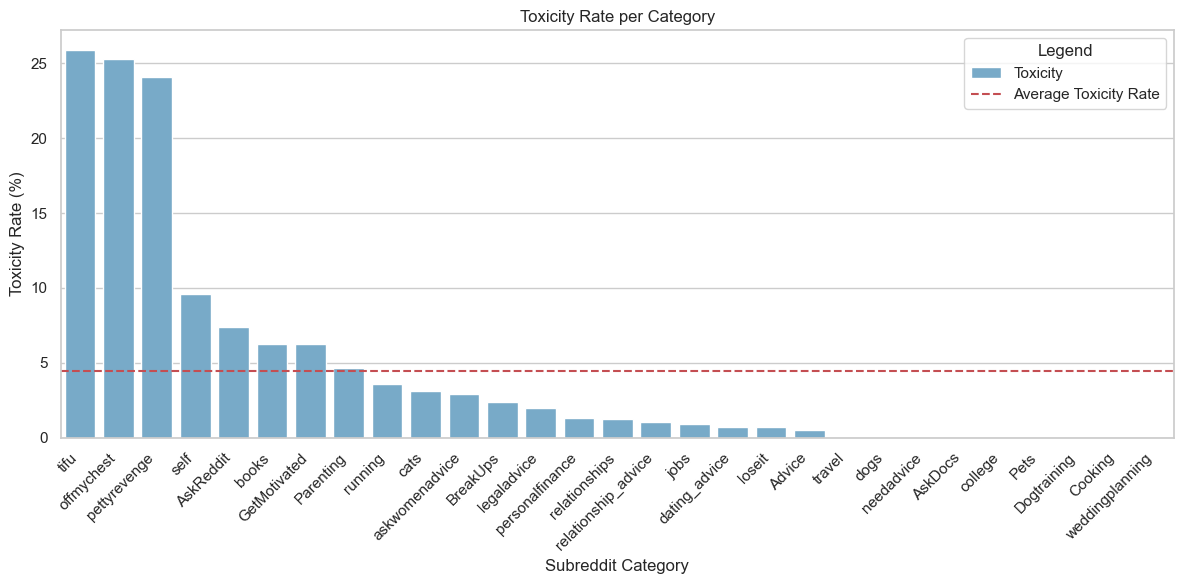

In [40]:
# Plot the Toxicity Rate with the average Toxicity Rate

toxicity_rates = toxicity_analysis_df.groupby('subreddit_category')['toxicity_label'].mean().reset_index()
toxicity_rates['toxicity_rate'] = toxicity_rates['toxicity_label'] * 100

toxicity_rates = toxicity_rates.sort_values(by='toxicity_rate', ascending=False)

plt.figure(figsize=(12, 6))

dark_blue_palette = sns.color_palette("Blues", n_colors=1)

toxicity_rates['hue'] = 'Toxicity'

barplot = sns.barplot(x='subreddit_category', y='toxicity_rate', 
                      data=toxicity_rates, 
                      hue='hue', 
                      palette=dark_blue_palette)

plt.axhline(y=toxicity_rates['toxicity_rate'].mean(), color='r', linestyle='--', label='Average Toxicity Rate')

plt.xticks(rotation=45, ha='right')
plt.yticks(range(0, 30, 5))
plt.xlabel('Subreddit Category')
plt.ylabel('Toxicity Rate (%)')
plt.title('Toxicity Rate per Category')
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()

In [41]:
def bootstrap_toxicity(df: pd.DataFrame, toxic_categories: pd.Index, n_iterations: int = 1000) -> pd.DataFrame:
    results = {}
    
    for category in toxic_categories:
        rates = []
        for _ in range(n_iterations):
            sample = df[df['subreddit_category'] == category].sample(frac=1, replace=True)
            rates.append(sample['toxicity_label'].mean())
        results[category] = {
            'mean_tox_rate': np.mean(rates),
            'lower_ci': np.percentile(rates, 2.5),
            'upper_ci': np.percentile(rates, 97.5)
        }

    return pd.DataFrame(results).T

toxic_categories = toxicity_analysis_df.groupby('subreddit_category')['toxicity_label'].sum()
toxic_categories = toxic_categories[toxic_categories > 0].index

bootstrapped_results_toxic = bootstrap_toxicity(toxicity_analysis_df, toxic_categories)
bootstrapped_results_toxic['toxicity_rate_percent'] = bootstrapped_results_toxic['mean_tox_rate'] * 100

bootstrapped_results_toxic = bootstrapped_results_toxic.sort_values(by="toxicity_rate_percent", ascending=False)
bootstrapped_results_toxic


,mean_tox_rate,lower_ci,upper_ci,toxicity_rate_percent
tifu,0.258271,0.226562,0.290365,25.827083
offmychest,0.253348,0.183544,0.316456,25.334810
pettyrevenge,0.239352,0.129630,0.351852,23.935185
self,0.096510,0.048077,0.153846,9.650962
AskReddit,0.073970,0.060920,0.087492,7.397019
GetMotivated,0.062625,0.000000,0.187500,6.262500
books,0.061562,0.000000,0.187500,6.156250
Parenting,0.047256,0.000000,0.116279,4.725581
running,0.034196,0.000000,0.089286,3.419643
cats,0.030875,0.000000,0.094531,3.087500


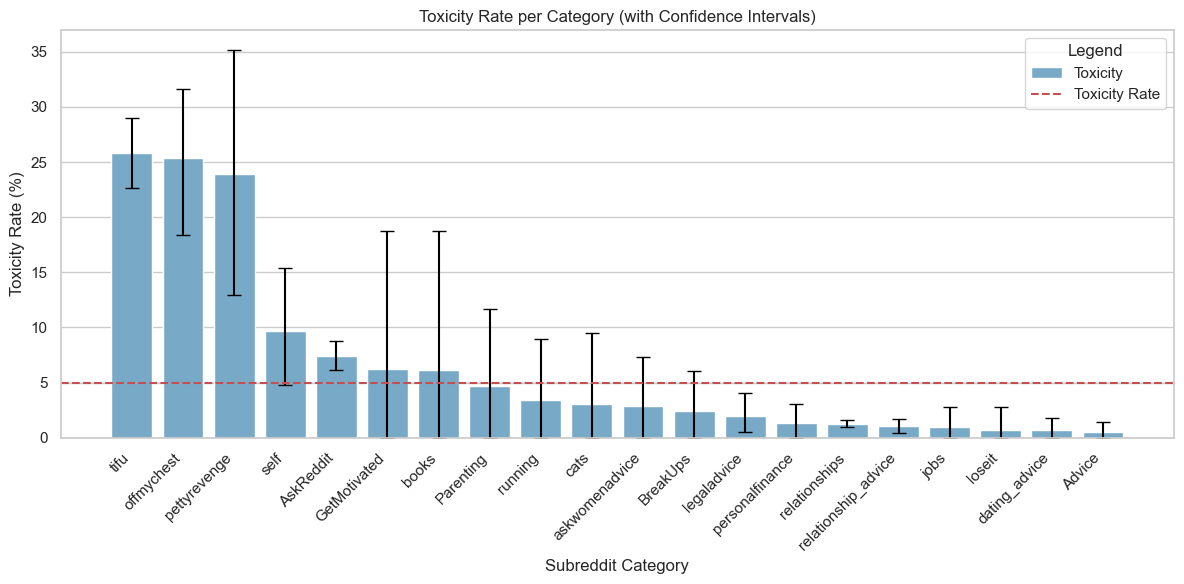

In [42]:
plt.figure(figsize=(12, 6))

bootstrapped_results_toxic['hue'] = 'Toxicity'
bootstrapped_results_toxic = bootstrapped_results_toxic.sort_values(by='toxicity_rate_percent', ascending=False)



barplot = sns.barplot(x=bootstrapped_results_toxic.index, 
                      y='toxicity_rate_percent',   
                      data=bootstrapped_results_toxic.reset_index(), 
                      palette=dark_blue_palette,
                      hue='hue')

for index, row in bootstrapped_results_toxic.iterrows():
    lower_error = (row['mean_tox_rate'] - row['lower_ci']) * 100
    upper_error = (row['upper_ci'] - row['mean_tox_rate']) * 100
    
    plt.errorbar(x=index, 
                 y=row['toxicity_rate_percent'], 
                 yerr=[[lower_error], [upper_error]], 
                 fmt='none', 
                 c='black', 
                 capsize=5)

plt.axhline(y=5, color='r', linestyle='--', label='Toxicity Rate')
plt.xticks(ticks=np.arange(len(bootstrapped_results_toxic.index)), 
           labels=bootstrapped_results_toxic.index, 
           rotation=45, ha='right')
plt.yticks(range(0, 40, 5))
plt.xlabel('Subreddit Category')
plt.ylabel('Toxicity Rate (%)')
plt.title('Toxicity Rate per Category (with Confidence Intervals)')
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()

The dataframe and it's plot suggests that toxicity rates in categories may vary widely. <br> For example, the actual toxicity for "pettyrevenge" could be anywhere between 12,96% and 35,12%. <br>
The confidence interval for "tifu" is compared to "pettyrevenge" relatively narrow, indicating that the estimate for this category is relatively stable.

In [43]:
# Calculate the difference between upper and lower confidence intervals
bootstrapped_results_toxic['ci_difference'] = bootstrapped_results_toxic['upper_ci'] - bootstrapped_results_toxic['lower_ci']

threshold = 5  
sorted_df = bootstrapped_results_toxic[bootstrapped_results_toxic['toxicity_rate_percent'] > threshold]

# Sort by the CI difference
sorted_df = sorted_df.sort_values(by='toxicity_rate_percent', ascending=False)
sorted_df = sorted_df.drop(columns=['hue'])

sorted_df

,mean_tox_rate,lower_ci,upper_ci,toxicity_rate_percent,ci_difference
tifu,0.258271,0.226562,0.290365,25.827083,0.063802
offmychest,0.253348,0.183544,0.316456,25.334810,0.132911
pettyrevenge,0.239352,0.129630,0.351852,23.935185,0.222222
self,0.096510,0.048077,0.153846,9.650962,0.105769
AskReddit,0.073970,0.060920,0.087492,7.397019,0.026572
GetMotivated,0.062625,0.000000,0.187500,6.262500,0.187500
books,0.061562,0.000000,0.187500,6.156250,0.187500


In [44]:
# Remove all where lower CI starts at 0
narrow_ci_df = sorted_df[sorted_df['lower_ci'] != 0]
narrow_ci_sorted = narrow_ci_df.sort_values(by='lower_ci', ascending=True)
narrow_ci_df

,mean_tox_rate,lower_ci,upper_ci,toxicity_rate_percent,ci_difference
tifu,0.258271,0.226562,0.290365,25.827083,0.063802
offmychest,0.253348,0.183544,0.316456,25.334810,0.132911
pettyrevenge,0.239352,0.129630,0.351852,23.935185,0.222222
self,0.096510,0.048077,0.153846,9.650962,0.105769
AskReddit,0.073970,0.060920,0.087492,7.397019,0.026572


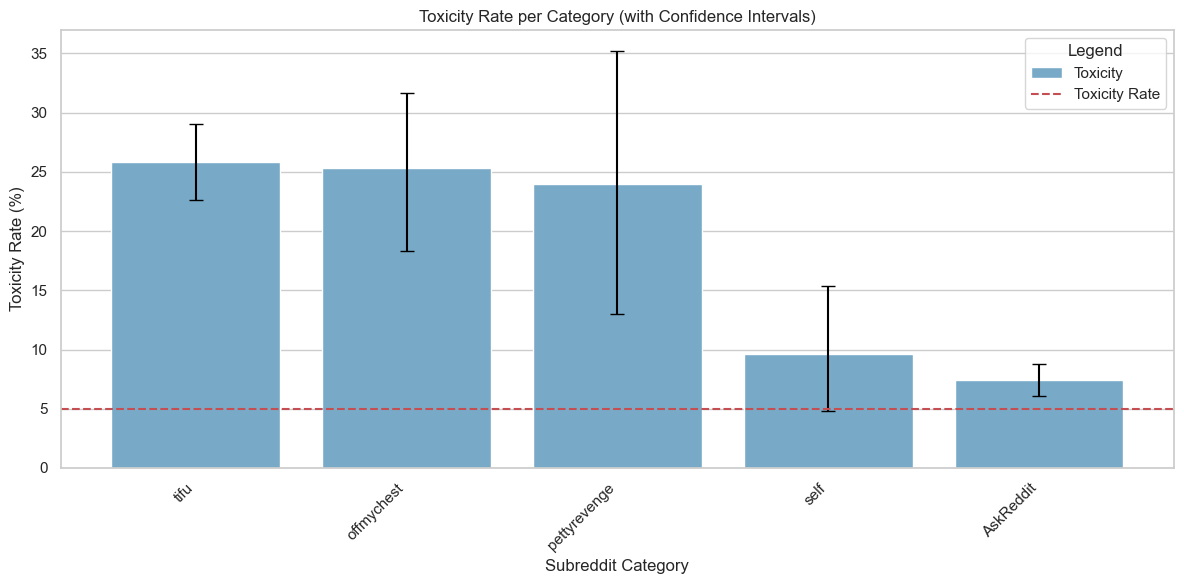

In [45]:
narrow_ci_df = narrow_ci_df.copy()
narrow_ci_df['hue'] = 'Toxicity'
narrow_ci_df = narrow_ci_df.sort_values(by='toxicity_rate_percent', ascending=False)

plt.figure(figsize=(12, 6))

barplot = sns.barplot(x=narrow_ci_df.index, 
                      y='toxicity_rate_percent',  
                      data=narrow_ci_df.reset_index(), 
                      palette=dark_blue_palette,  
                      hue='hue')

for index, row in narrow_ci_df.iterrows():
    lower_error = (row['mean_tox_rate'] - row['lower_ci']) * 100
    upper_error = (row['upper_ci'] - row['mean_tox_rate']) * 100
    
    plt.errorbar(x=narrow_ci_df.index.get_loc(index),  
                 y=row['toxicity_rate_percent'], 
                 yerr=[[lower_error], [upper_error]], 
                 fmt='none', 
                 c='black', 
                 capsize=5)

plt.axhline(y=5, color='r', linestyle='--', label='Toxicity Rate')
plt.xticks(ticks=np.arange(len(narrow_ci_df.index)), 
           labels=narrow_ci_df.index, 
           rotation=45, ha='right')
plt.yticks(range(0, 40, 5))
plt.xlabel('Subreddit Category')
plt.ylabel('Toxicity Rate (%)')
plt.title('Toxicity Rate per Category (with Confidence Intervals)')
plt.legend(title='Legend', loc='upper right')
plt.tight_layout()
plt.show()

Now we can say for sure that "tifu" is the most toxic category in our Dataset. <br>
"offmychest" and "pettyrevenge" are also quite toxic, even though their Confidence Interval isn't very narrow, the lower CI is still higher than from all of the others.<br>
"self" and "AskReddit" could also be toxic, but their toxicity rate overall isn't that high.

## Chi Sqared Test: Test if the difference between the Categories is significant

In [46]:
# Build a Contingency Table

# Group by subreddit_category and toxicity_label and count the number of posts
contingency_table = toxicity_analysis_df.groupby(['subreddit_category', 'toxicity_label']).size().unstack(fill_value=0)

# rename columns for better readability
contingency_table.columns = ['Non-Toxic', 'Toxic']

contingency_table

,Non-Toxic,Toxic
subreddit_category,,
Advice,207,1
AskDocs,28,0
AskReddit,1429,114
BreakUps,81,2
Cooking,11,0
Dogtraining,36,0
GetMotivated,15,1
Parenting,41,2
Pets,36,0


In [47]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square-Value: {chi2}")
print(f"p-value: {p}")

Chi-Square-Value: 1382.078940424407
p-value: 1.0300628543219002e-273


A high chi-squared value (as in our case) indicates that there is a large deviation between the observed and expected frequencies. This indicates that the distribution of toxicity in the different subreddit categories is not random. <br>
A p-value of 1.0300628543219002e-273 is very low, indicating that it is very likely that the differences between the categories are significant. A p-value below 0.05 is considered significant, so the result is very significant. <br>
Because the p-value is so low, we can say with high confidence that there are significant differences in toxicity between the different subreddit categories. This means that certain categories contain more toxic content than others. <br> This rejects our Null-Hypothesis and supports our Hypothesis. <br>
--> There are significant differences in toxicity between the different subreddit categories.

# Hypothesis: Longer posts are more likely to be non-toxic compared to shorter posts.
# Null-Hypothesis: There is no difference in the mean word count between toxic posts and non-toxic posts

## First Impressions

In [48]:
toxicity_analysis_df

,subreddit_category,word_count,preprocessed,toxicity_label
0,Advice,228,"i 'm 23 , moved back in with parents . how do ...",0
1,Advice,143,always feel an overwhelming lack of confidence...,0
2,Advice,233,"dealing with this break up hey there , this mo...",0
3,Advice,398,disagreement when picking rooms in the new hou...,0
4,Advice,226,i do n't know what i believe i do n't typicall...,0
...,...,...,...,...
11648,weddingplanning,236,budgeting .. where to start ? hi weddit ! firs...,0
11649,weddingplanning,370,disagreement with fh about one person 's weddi...,0
11650,weddingplanning,289,what 's next ? destination wedding we are gett...,0
11651,weddingplanning,353,how do i manage a tricky situation with my fut...,0


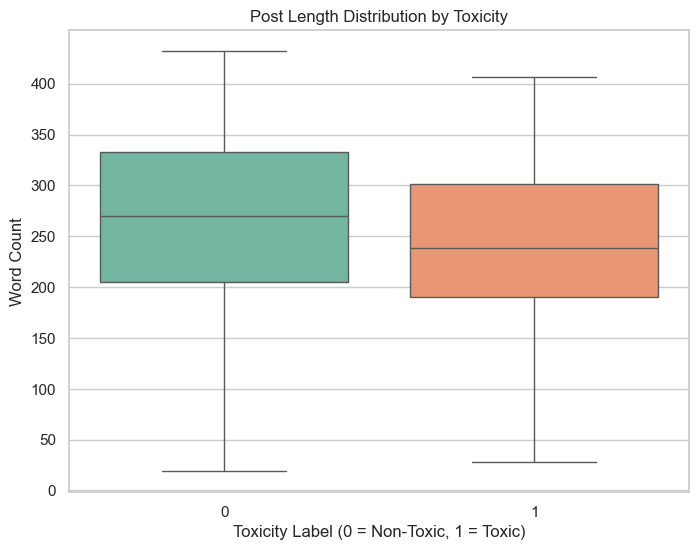

In [49]:
sns.set_theme(style="whitegrid")

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='toxicity_label', y='word_count', data=toxicity_analysis_df, hue='toxicity_label',palette='Set2', legend=False)
plt.title('Post Length Distribution by Toxicity')
plt.xlabel('Toxicity Label (0 = Non-Toxic, 1 = Toxic)')
plt.ylabel('Word Count')
plt.yticks(range(0, 450, 50))
plt.show()

Non-Toxic Posts: <br>
The median word count is slightly under 275 words. <br>
The IQR shows that the bulk of non-toxic posts are between approximately slightly under 200 and 300 words.<br>
The range extends from about a little under 25 to over 425 words, meaning there is some variation in post length.<br>
<br>

Toxic Posts: <br>
The median word count for toxic posts is slightly under 250 words.<br>
The IQR for toxic posts is wider, indicating more variability in the lengths of toxic posts.<br>
Toxic posts range from a bit over 25 to over 400 words.<br>
<br>

Median Comparison: <br>
Both toxic and non-toxic posts have similar median word counts, so the central tendency of the word count doesn't seem to differ much between the two groups. <br><br>
Variability: <br>Non-Toxic posts have a slightly larger spread (IQR), meaning there's slightly more variability in post length among non-toxic posts compared to toxic ones.<br>

## Check for Normaility and Homogeneity of Variance

In [50]:
def check_normality_and_homogeneity(data: Tuple[pd.DataFrame, pd.DataFrame], transformation_name: str, alpha: float = 0.05) -> None:
    """
    Function to check normality of a given dataset using Anderson-Darling (non-toxic) 
    and Shapiro-Wilk test (toxic), and homogeneity of variances using Levene's test. 
    Visualizes the distribution using histograms.

    Parameters:
    - data: tuple of two datasets (non_toxic, toxic)
    - transformation_name: Name of the transformation (e.g., 'Yeo-Johnson', 'Box-Cox')
    - alpha: Significance level for normality and homogeneity tests (default 0.05)
    """
    non_toxic, toxic = data

    # Shapiro-Wilk Test for Toxic Data
    shapiro_toxic = stats.shapiro(toxic)
    print(f"{transformation_name} Transformed Data (Toxic): Shapiro-Wilk Statistic={shapiro_toxic.statistic}, p-value={shapiro_toxic.pvalue}")
    if shapiro_toxic.pvalue > alpha:
        print("Toxic Posts: Distribution can be considered normally distributed.")
    else:
        print("Toxic Posts: Distribution is not normally distributed.")

    # Anderson-Darling Test for Non-Toxic Data
    anderson_darling_non_toxic = stats.anderson(non_toxic)
    print(f"{transformation_name} Transformed Data (Non-Toxic): Anderson-Darling Statistic={anderson_darling_non_toxic.statistic}")
    print(f"Critical Values: {anderson_darling_non_toxic.critical_values}")
    
    # 5% significance level (index 2 corresponds to 5%)
    if anderson_darling_non_toxic.statistic > anderson_darling_non_toxic.critical_values[2]:
        print("Non-Toxic Posts: Distribution is not normally distributed.")
    else:
        print("Non-Toxic Posts: Distribution can be considered normally distributed.")

    # Levene's Test for Homogeneity of Variances
    levene_stat, levene_p = stats.levene(non_toxic, toxic)
    print(f"Levene's Test for Homogeneity of Variances: Statistic={levene_stat}, p-value={levene_p}")
    if levene_p > alpha:
        print("Assumption of Homogeneity of Variances is met.")
    else:
        print("Assumption of Homogeneity of Variances is not met.")
    
    # Histogram for transformed data
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(non_toxic, kde=True, color='blue', bins=30)
    plt.title(f'{transformation_name} Transformed Word Count (Non-Toxic)')
    plt.xlabel(f'{transformation_name} Transformed Word Count')

    plt.subplot(1, 2, 2)
    sns.histplot(toxic, kde=True, color='red', bins=30)
    plt.title(f'{transformation_name} Transformed Word Count (Toxic)')
    plt.xlabel(f'{transformation_name} Transformed Word Count')

    plt.tight_layout()
    plt.show()

In [51]:
# Separate the data into toxic and non-toxic groups
non_toxic = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 0]['word_count']
toxic = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['word_count']

print(f'Toxic: {toxic.shape[0]}')
print(f'Non-Toxic:{non_toxic.shape[0]}')

Toxic: 488
Non-Toxic:11165


We cannot rely on the Shapiro-Wilk Test on data with N>5000. <br> 
That's why we use the Shapiro-Wilk Test for Toxic Posts (N<5000) and the Anderson-Darling Test for Non-Toxic Posts (N>5000). <br>
The function ```check_normality_and_homogeneity()``` defined above does exactly that.

Not Transformed Data (Toxic): Shapiro-Wilk Statistic=0.977073073387146, p-value=6.088267809900572e-07
Toxic Posts: Distribution is not normally distributed.
Not Transformed Data (Non-Toxic): Anderson-Darling Statistic=65.6498263677895
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Non-Toxic Posts: Distribution is not normally distributed.
Levene's Test for Homogeneity of Variances: Statistic=3.7197278854136275, p-value=0.053797398289497596
Assumption of Homogeneity of Variances is met.


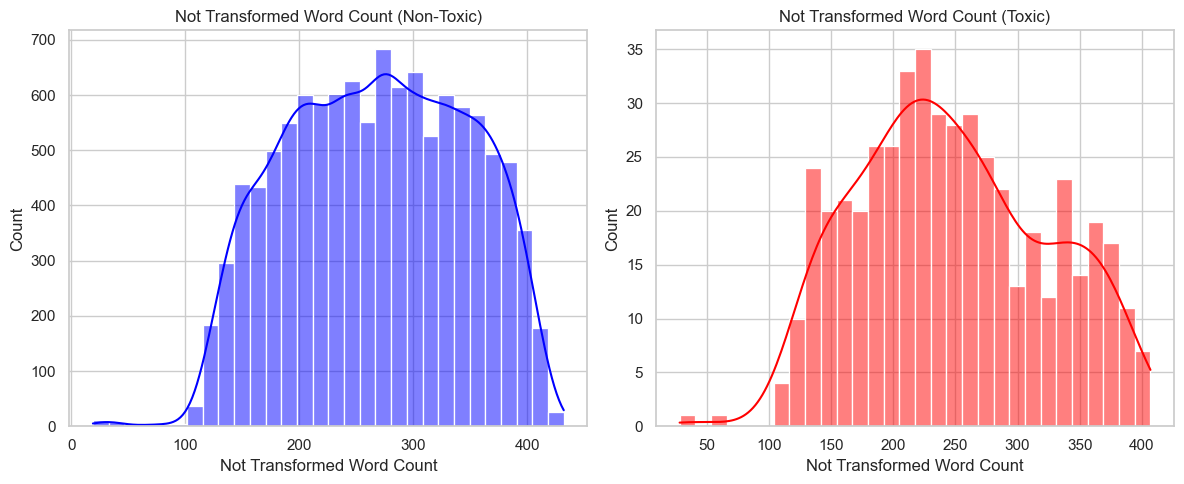

In [52]:
check_normality_and_homogeneity((non_toxic, toxic), "Not")

### Transformations (for dealing with normality issues) and Further Analysis

#### Log transformation

Log-Transformed Transformed Data (Toxic): Shapiro-Wilk Statistic=0.9501909017562866, p-value=9.35147445590978e-12
Toxic Posts: Distribution is not normally distributed.
Log-Transformed Transformed Data (Non-Toxic): Anderson-Darling Statistic=123.90966912127988
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Non-Toxic Posts: Distribution is not normally distributed.
Levene's Test for Homogeneity of Variances: Statistic=0.1684594111874304, p-value=0.6814921699576131
Assumption of Homogeneity of Variances is met.


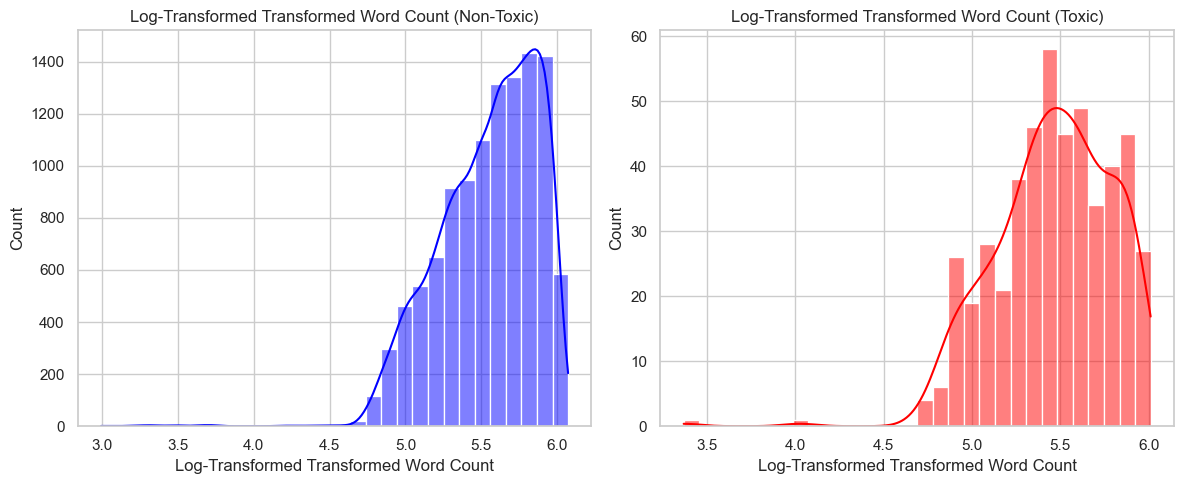

In [53]:
# Try log transformation for dealing with normality
toxicity_analysis_df['log_word_count'] = np.log(toxicity_analysis_df['word_count'] + 1)  # +1 to avoid log(0)

non_toxic_log = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 0]['log_word_count']
toxic_log = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['log_word_count']

check_normality_and_homogeneity((non_toxic_log, toxic_log), "Log-Transformed")

#### Square Root Transformation

Square-Root-Transformed Transformed Data (Toxic): Shapiro-Wilk Statistic=0.9794356822967529, p-value=2.199354867116199e-06
Toxic Posts: Distribution is not normally distributed.
Square-Root-Transformed Transformed Data (Non-Toxic): Anderson-Darling Statistic=77.29143454510995
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Non-Toxic Posts: Distribution is not normally distributed.
Levene's Test for Homogeneity of Variances: Statistic=0.5095625465638418, p-value=0.4753425867861636
Assumption of Homogeneity of Variances is met.


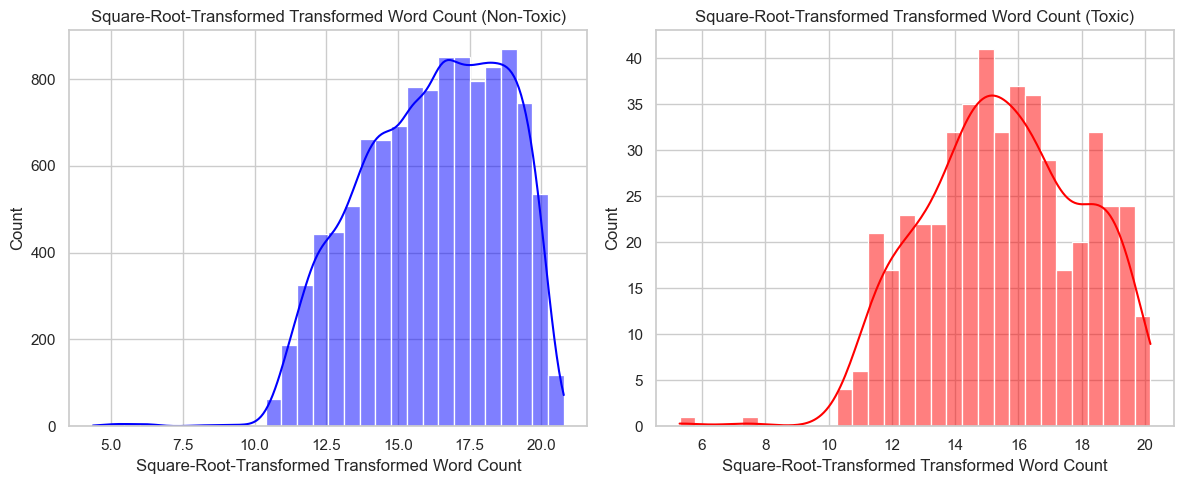

In [54]:
toxicity_analysis_df['sqrt_word_count'] = np.sqrt(toxicity_analysis_df['word_count'])
non_toxic_sqr = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 0]['sqrt_word_count']
toxic_sqr = toxicity_analysis_df[toxicity_analysis_df['toxicity_label'] == 1]['sqrt_word_count']

check_normality_and_homogeneity((non_toxic_sqr, toxic_sqr), "Square-Root-Transformed")

#### Box-Cox Transformation

Box-Cox-Transformed Transformed Data (Toxic): Shapiro-Wilk Statistic=0.9810221791267395, p-value=5.442221663543023e-06
Toxic Posts: Distribution is not normally distributed.
Box-Cox-Transformed Transformed Data (Non-Toxic): Anderson-Darling Statistic=65.41056841633144
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Non-Toxic Posts: Distribution is not normally distributed.
Levene's Test for Homogeneity of Variances: Statistic=767.9990624643503, p-value=9.331000395666339e-164
Assumption of Homogeneity of Variances is not met.


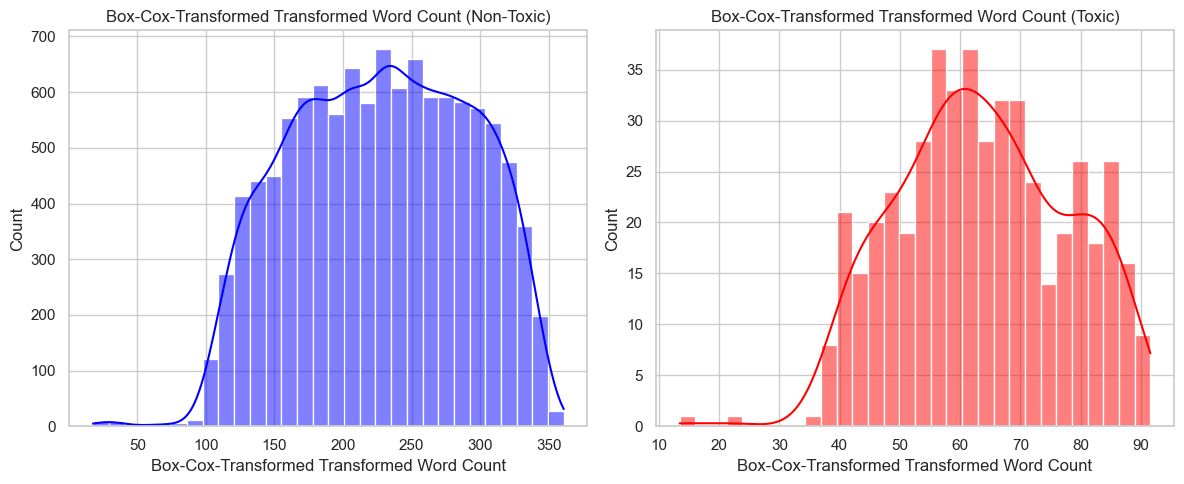

In [55]:
non_toxic_boxcox, _ = boxcox(non_toxic + 1)
toxic_boxcox, _ = boxcox(toxic + 1)

check_normality_and_homogeneity((non_toxic_boxcox, toxic_boxcox), "Box-Cox-Transformed")

#### Yeo-Johnson Transformation

Yeo-Johnson-Transformed Transformed Data (Toxic): Shapiro-Wilk Statistic=0.9810221791267395, p-value=5.442221663543023e-06
Toxic Posts: Distribution is not normally distributed.
Yeo-Johnson-Transformed Transformed Data (Non-Toxic): Anderson-Darling Statistic=65.41056841633326
Critical Values: [0.576 0.656 0.787 0.918 1.092]
Non-Toxic Posts: Distribution is not normally distributed.
Levene's Test for Homogeneity of Variances: Statistic=767.9990624643503, p-value=9.331000395666339e-164
Assumption of Homogeneity of Variances is not met.


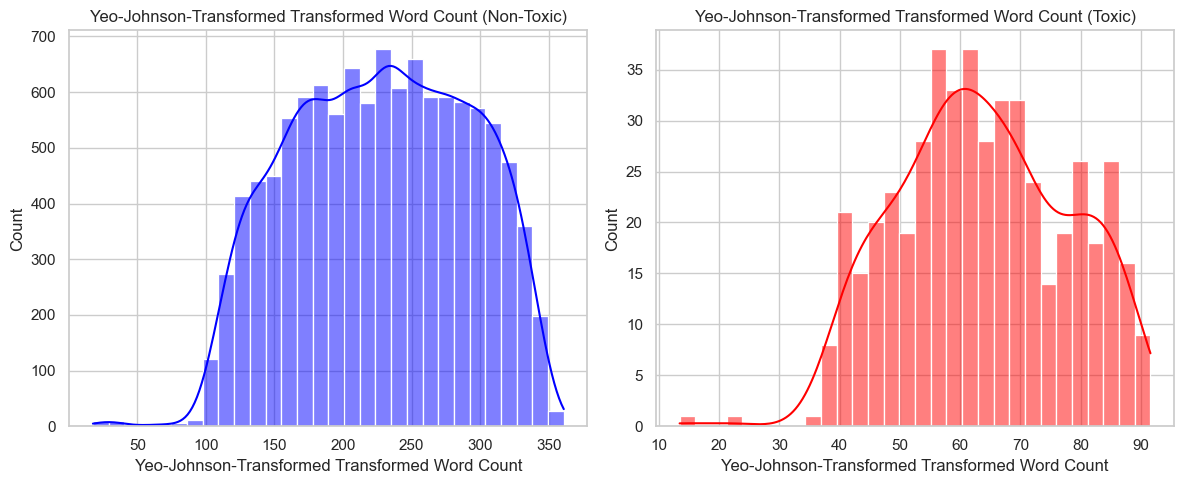

In [56]:
non_toxic_yj, _ = yeojohnson(non_toxic)
toxic_yj, _ = yeojohnson(toxic)

check_normality_and_homogeneity((non_toxic_yj, toxic_yj), "Yeo-Johnson-Transformed")

## Mann-Whitney U-Test

Even though the Assumption on the Homogeneity of Variance is depending on the transformation is sometimes met, the assumptions of normality were not met regardless of which transformaton we did. <br>
The Mann-Whitney U-Test is suitable given the non-normality. <br>

In [57]:
_, mann_whitney_p = stats.mannwhitneyu(non_toxic, toxic)
print(f"{mann_whitney_p}")

4.8356092952316146e-09


The very low p-value (< 0.05) indicates a significant difference in word count between toxic and non-toxic posts, leading to the rejection of the null hypothesis. <br>
--> There is a difference in the word count between toxic posts and non-toxic posts.